### Setting up the system

Since we started with cats and dogs, let us take up the dataset of Cat and Dog Images. The original training dataset on Kaggle has 25000 images of cats and dogs and the test dataset has 10000 unlabelled images

In [4]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O /tmp/cats_and_dogs_filtered.zip

--2021-08-04 17:16:43--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.103.128, 108.177.120.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.103.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  89.5MB/s    in 0.7s    

2021-08-04 17:16:44 (89.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



Import the basic libraries

In [2]:
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

### Preparing the Dataset

We will first prepare the dataset and separate out the images:

We first divide the folder contents into the train and validation directories.
Then, in each of the directories, create a separate directory for cats that contains only cat images, and a separate director for dogs having only dog images

In [5]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Let us check if the images have been loaded correctly

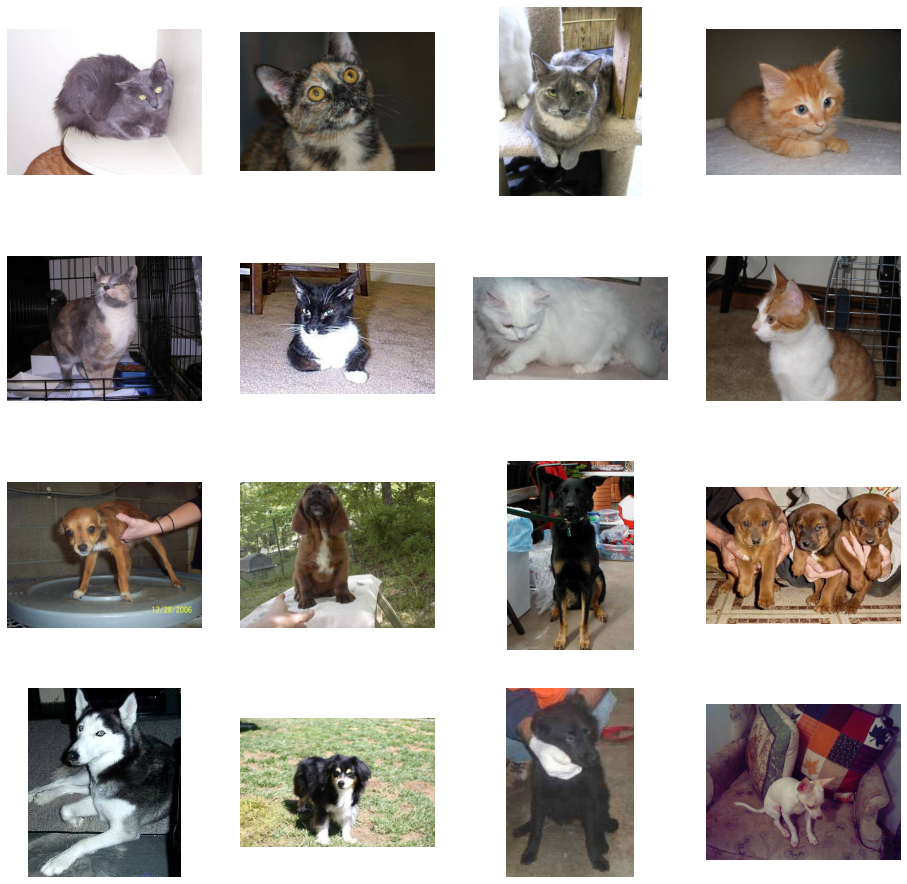

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )


next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Pre-Trained Models for Image Classification

### VGG-16

Step 1: Image Augmentation

Since we took up a much smaller dataset of images earlier, we can make up for it by augmenting this data and increasing our dataset size. If you are working with the original larger dataset, you can skip this step and move straight on to building the model

In [7]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

Step 2: Training and Validation Sets

In [8]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Step 3: Loading the Base Model

We will be using only the basic models, with changes made only to the final layer. This is because this is just a binary classification problem while these models are built to handle up to 1000 classes.

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58892288/58889256 [==============================] - 0s 0us/step


Since we don’t have to train all the layers, we make them non_trainable:

In [10]:
for layer in base_model.layers:
    layer.trainable = False

Step 4: Compile and Fit

We will then build the last fully-connected layer. I have just used the basic settings, but feel free to experiment with different values of dropout, and different Optimisers and activation functions.

In [11]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


We will now build the final model based on the training and validation sets we created earlier. Please note to use the original directories itself instead of the augmented datasets I have used below. I have used just 10 epochs, but you can also increase them to get better results:

In [12]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 5)

Epoch 1/5
  4/100 [>.............................] - ETA: 16:39 - loss: 1.8690 - acc: 0.5500

KeyboardInterrupt: ignored

you can see, we were able to achieve a validation Accuracy of 93% with just 5 epochs and without any major changes to the model

### 2. Inception

Step 1: Data Augmentation

You will note that I am not performing extensive data augmentation. The code is the same as before. I have just changed the image dimensions for each model.

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

Step 2: Training and Validation Generators

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150))
validation_generator = test_datagen.flow_from_directory(validation_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150))


Step 3: Loading the Base Model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

Step 4: Compile and Fit
Just like VGG-16, we will only change the last layer.

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

We perform the following operations:

- Flatten the output of our base model to 1 dimension
- Add a fully connected layer with 1,024 hidden units and ReLU activation
- This time, we will go with a dropout rate of 0.2
- Add a final Fully Connected Sigmoid Layer
- We will again use RMSProp, though you can try out the Adam Optimiser too

In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

We will then fit the model:

In [ ]:
inc_history = model.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 5)

We can see that we get 96% Validation accuracy in 5 epochs. Also note, how this model is much faster than VGG16. Each epoch is taking around only 1/4th the time that each epoch in VGG16. Of course, you can always experiment with the different hyperparameter values and see how much better/worse it performs

### 3. ResNet50

Let us now use ResNet50 on our dataset:

Step 1: Data Augmentation and Generators

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory( validation_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Step 2: Import the base model

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

Again, we are using only the basic ResNet model, so we will keep the layers frozen and only modify the last layer:

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

Step 3: Build and Compile the Model

Here, I would like to show you an even shorter code for using the ResNet50 model. We will use this model just as a layer in a Sequential model, and just add a single Fully Connected Layer on top of it.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

base_model = Sequential()
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model.add(Dense(1, activation='sigmoid'))

We compile the model and this time let us try the SGD optimizer:

In [ ]:
base_model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

Step 4: Fitting the model

In [ ]:
resnet_history = base_model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

You can see how well it performs on our dataset and this makes ResNet50 one of the most widely used Pre-trained models